In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

from alexnet import AlexNet
from image_loader import load_images
from util import shuffle, get_batch

### Set hyperparameters

In [2]:
learning_rate = 0.001
num_epochs = 3
batch_size = 128

dropout_rate = 0.5
num_classes = 2

# how often to write tf.summary to disk
display_step = 20

### Build computation graph

Building the CNN is in the `./alexnet.py` file. This is also used in `./eval.py` which just makes predictions, so it makes sense to put it in a separate file in order to reuse.

In [3]:
X = tf.placeholder(tf.float32, shape=(batch_size, 150, 150, 1))
Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes))
dropout = tf.placeholder(tf.float32)

model = AlexNet(X, dropout, num_classes)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y))

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimization_op = optimizer.minimize(loss)

tf.summary.scalar('loss', loss)

with tf.name_scope("accuracy"):
    predictions = tf.argmax(model.logits, axis=1)
    correct_predictions = tf.equal(predictions, tf.argmax(Y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

tf.summary.scalar('training_accuracy', accuracy)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./tensorboard")
saver = tf.train.Saver()

### Load image data into memory

Only takes about 1-2GB of memory, so we can load it all into memory at once.

In [4]:
molecule_images = load_images("./positives/images/*.png")
non_molecule_images = load_images("./negatives/tiles/*.png")

### Munge data

Generate the right labels, shuffle randomly, and partition training and test sets.

In [7]:
np.random.seed(9001)

n_pos = molecule_images.shape[0]
n_neg = molecule_images.shape[0]

positive_labels = np.stack((np.ones(n_pos), np.zeros(n_pos)), axis=1)
negative_labels = np.stack((np.zeros(n_neg), np.ones(n_neg)), axis=1)

x = np.vstack((molecule_images, non_molecule_images))
y = np.vstack((positive_labels, negative_labels))

m = x.shape[0]

x, y = shuffle(x, y)

train_x = x[:-2000]
train_y = y[:-2000]

test_x = x[-2000:]
test_y = y[-2000:]

### Preview
Display some labels and images.

[ 1.  0.]
[ 1.  0.]
[ 1.  0.]
[ 0.  1.]
[ 0.  1.]
[ 0.  1.]
[ 1.  0.]
[ 1.  0.]
[ 0.  1.]
[ 1.  0.]


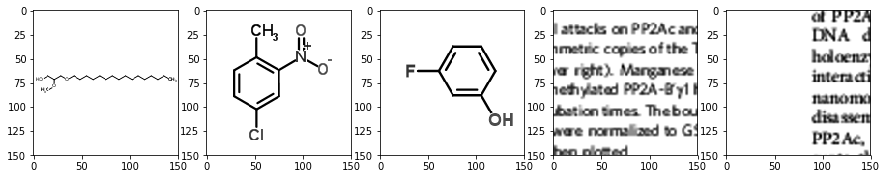

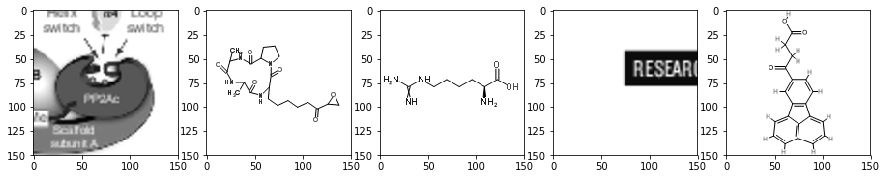

In [8]:
for i in range(2):
    fig = plt.figure(figsize=(15, 15))
    for j in range(5):
        print(y[i * 5 + j])
        sub = fig.add_subplot(1, 5, j + 1)
        sub.imshow(np.squeeze(x[i * 5 + j]), cmap="gray")

plt.show()        

### Training

In [6]:
training_batches_per_epoch = int(np.floor(train_x.shape[0] / batch_size))
test_batches_per_epoch = int(np.floor(test_x.shape[0] / batch_size))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x, train_y = shuffle(train_x, train_y)
        
        for step in tqdm(range(training_batches_per_epoch)):
            x_batch, y_batch = get_batch(train_x, train_y, step, batch_size)
            sess.run(optimization_op, feed_dict={X: x_batch, Y: y_batch, dropout: dropout_rate })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(merged_summary, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                writer.add_summary(summ, epoch * training_batches_per_epoch + step)
                writer.flush()

        test_acc = 0
        test_count = 0
        for step in range(test_batches_per_epoch):
            x_batch, y_batch = get_batch(test_x, test_y, step, batch_size)
            acc = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
            test_acc += acc
            test_count += 1

        print("test accuracy = {:.4f}".format(test_acc / test_count))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./model.ckpt")

2017-12-26 21:23:09.631089 epoch number: 1


100%|██████████| 138/138 [05:42<00:00,  2.48s/it]


test accuracy = 0.9974
2017-12-26 21:29:01.926146 epoch number: 2


100%|██████████| 138/138 [05:43<00:00,  2.49s/it]


test accuracy = 0.9984
2017-12-26 21:34:55.223139 epoch number: 3


100%|██████████| 138/138 [05:48<00:00,  2.52s/it]


test accuracy = 0.9990
